In [1]:
import glob
import csv
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
!pip install funcy
import funcy
from funcy import print_durations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.cuda.amp import GradScaler
torch.backends.cudnn.benchmark = True
import datetime
import gc
import pickle
from torchsummary import summary

/opt/conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Defaulting to user installation because normal site-packages is not writeable


In [2]:
start_date = '1980-01-01'

In [3]:
returns_df = pd.read_csv('returns.csv',index_col=0).loc[start_date:]
# returns_df = returns_df.dropna(axis=0,thresh=500).dropna(axis=1,thresh=500)
equity_idx = returns_df.columns
date_idx = returns_df.index
returns_df = returns_df.clip(returns_df.quantile(0.01,axis=1),returns_df.quantile(0.99,axis=1),axis=0)
returns_df

,0081A,0091A,0099A,0127A,0138A,0146A,0153A,0183B,0223B,0230B,...,ZVXI,ZWRK,ZWS,ZXAIY,ZY,ZYME,ZYNE,ZYXI,ZZ,ZZ1
datadate,,,,,,,,,,,,,,,,,,,,,
1980-01-31,NaN,0.012579,NaN,0.068182,0.039548,NaN,NaN,NaN,0.007752,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.137500
1980-02-29,NaN,-0.006211,NaN,0.000000,NaN,NaN,NaN,NaN,-0.086462,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.164835
1980-03-31,NaN,-0.306250,NaN,0.007092,NaN,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.118421
1980-04-30,NaN,0.252252,NaN,-0.126761,NaN,NaN,NaN,NaN,0.139130,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.029851
1980-05-31,NaN,0.071942,NaN,0.177419,NaN,NaN,NaN,NaN,0.036336,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.123077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.001025,-0.033076,0.001111,-0.145283,-0.096180,-0.096606,0.021548,NaN,NaN
2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.001026,0.038516,0.054384,-0.261589,-0.184983,-0.167630,-0.221094,NaN,NaN
2022-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.004620,-0.160989,0.084211,-0.222720,-0.456986,-0.093750,-0.115145,NaN,NaN


In [4]:
feat_comb_df = pd.read_csv('features_combined.csv').set_index(['tic','rdq']).drop(['FYEARQ','FQTR'],axis=1)
feat_comb_df = feat_comb_df[sorted(feat_comb_df.columns)]
feat_comb_df

A2ME  AC       ATO  BEME         C  CF  CF2P       CTO  \
tic   rdq                                                                      
0015B 1984-01-16  0.381941 NaN       NaN   NaN  0.214994 NaN   NaN       NaN   
      1984-03-15  0.557109 NaN       NaN   NaN  0.274170 NaN   NaN       NaN   
      1984-05-25  0.590922 NaN       NaN   NaN  0.140065 NaN   NaN       NaN   
      1984-08-27  0.651735 NaN       NaN   NaN  0.009504 NaN   NaN       NaN   
      1985-01-01  0.871765 NaN  0.760755   NaN  0.019574 NaN   NaN  0.778316   
...                    ...  ..       ...   ...       ...  ..   ...       ...   
ZZZ1  2000-08-14  1.171566 NaN  0.073420   NaN  0.036884 NaN   NaN  0.067789   
      2000-11-13  1.185838 NaN  0.079706   NaN  0.029840 NaN   NaN  0.069810   
      2001-03-28       NaN NaN  0.075438   NaN  0.041668 NaN   NaN  0.065717   
      2001-05-14       NaN NaN  0.085226   NaN  0.029079 NaN   NaN  0.082268   
      2001-08-13       NaN NaN  0.091314   NaN  0.040394 NaN   NaN  0.085981   

                       D2A       D2P  ...  OP       PCM        PM  PROF   Q  \
tic   rdq                             ...                                     
0015B 1984-01-16       NaN       NaN  ... NaN       NaN       NaN   NaN NaN   
      1984-03-15       NaN       NaN  ... NaN       NaN       NaN   NaN NaN   
      1984-05-25       NaN       NaN  ... NaN       NaN       NaN   NaN NaN   
      1984-08-27  0.015213  0.000000  ... NaN -0.968086  0.247569   NaN NaN   
      1985-01-01  0.012021  0.000000  ... NaN -0.950109  0.230870   NaN NaN   
...                    ...       ...  ...  ..       ...       ...   ...  ..   
ZZZ1  2000-08-14       NaN  0.006326  ... NaN  0.523240  1.000000   NaN NaN   
      2000-11-13       NaN  0.004737  ... NaN  0.559099  1.000000   NaN NaN   
      2001-03-28       NaN       NaN  ... NaN  0.540736  1.000000   NaN NaN   
      2001-05-14       NaN       NaN  ... NaN  0.622717  1.000000   NaN NaN   
      2001-08-13       NaN       NaN  ... NaN  0.653604  1.000000   NaN NaN   

                       RNA       ROA  ROE       S2P     SGA2S  
tic   rdq                                                      
0015B 1984-01-16       NaN       NaN  NaN       NaN       NaN  
      1984-03-15       NaN       NaN  NaN       NaN       NaN  
      1984-05-25       NaN       NaN  NaN       NaN       NaN  
      1984-08-27       NaN       NaN  NaN  1.418175  0.731681  
      1985-01-01  0.175636  0.125346  NaN  1.499765  0.748516  
...                    ...       ...  ...       ...       ...  
ZZZ1  2000-08-14  0.073420  0.018000  NaN  0.098857       NaN  
      2000-11-13  0.079706  0.021708  NaN  0.104211       NaN  
      2001-03-28  0.075438  0.021779  NaN       NaN       NaN  
      2001-05-14  0.085226  0.044324  NaN       NaN       NaN  
      2001-08-13  0.091314  0.062878  NaN       NaN       NaN  

[924199 rows x 29 columns]

In [5]:
MIN_AVAILABLE_FEATURES = feat_comb_df.shape[1]//2

full_df_lst = []
for date in tqdm(date_idx):
    sub = feat_comb_df.loc[feat_comb_df.index.get_level_values(1) < date]
    sub = sub.groupby(sub.index.get_level_values('tic')).last(1)
    sub = sub.transpose()
    
    sub = sub.rank(pct=True,axis=1)*2-1
    idx = (sub.isna().sum(axis=0) >= MIN_AVAILABLE_FEATURES).index
    sub = sub[idx].fillna(0)
    
#     sub = sub.fillna(sub.median(axis=1),axis=0)
    
    sub['date'] = date
    sub =  sub.set_index(['date',sub.index])
    
    full_df_lst.append(sub)
    


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 507/507 [01:48<00:00,  4.67it/s]


# Train Test Split

In [6]:
class AEDataSet(torch.utils.data.Dataset):
    def __init__(self, full_df_lst, returns_df, date_idx, start_i, end_i, rhs_input_assets=False,lag=1):
        self.full_df_lst = full_df_lst
        self.returns_df = returns_df
        self.date_idx = date_idx
        self.start_i, self.end_i = start_i, end_i
        self.rhs_input_assets = rhs_input_assets
        self.epsilon=1e-5
        self.lag=lag
        
        self.output_date_idx = date_idx[start_i+lag:end_i]
        
    def __len__(self):
        return self.end_i - self.start_i - self.lag
    def __getitem__(self, idx):
        input_idx = idx
        idx += self.start_i+self.lag
        date = self.date_idx[idx] # returns date
        
        mask = ~np.isnan(self.returns_df.loc[date].to_numpy())
        traded_assets_idx = self.returns_df.columns[mask]
        
        lhs = self.full_df_lst[idx - self.lag]
        lhs_idx = lhs.columns
        
        comb_idx = traded_assets_idx.intersection(lhs_idx)
        
        lhs = lhs.reindex(comb_idx,axis=1,fill_value=0).to_numpy()
        
        rhs_tmp = self.returns_df.loc[date,comb_idx]
        rhs_tmp = rhs_tmp.clip(rhs_tmp.quantile(0.01),rhs_tmp.quantile(0.99))
        output = rhs_tmp.to_numpy()

        lhs_tmp = np.concatenate([lhs,np.expand_dims(np.ones(lhs.shape[1]),0)],axis=0)
        
        
        if self.rhs_input_assets:
            rhs = output
        else:
            try:
                rhs = (np.linalg.inv(lhs_tmp @ lhs_tmp.T) @ lhs_tmp) @ rhs_tmp
            except Exception as e:
                print("idx:",input_idx)
                print(e)
                raise e
        return lhs,rhs,output,comb_idx
        
        
def collate_fn(batch):

    len_x = [len(output) for lhs,rhs,output,_ in batch]
    full_size = max(len_x)
    
    batch_lhs = [nn.functional.pad(torch.Tensor(lhs),pad=(0,full_size-lhs.shape[1],0,0)) for lhs,rhs,output,_ in batch]
    batch_rhs = [torch.Tensor(rhs) for lhs,rhs,output,_ in batch]
    batch_output = [nn.functional.pad(torch.Tensor(output),pad=(0,full_size-len(output))) for lhs,rhs,output,_ in batch]
    batch_assets = [idx for lhs,rhs,output,idx in batch]
    
    return torch.cat([x.unsqueeze(0) for x in batch_lhs]),\
        torch.cat([x.unsqueeze(0) for x in batch_rhs]),\
        torch.cat([x.unsqueeze(0) for x in batch_output]), torch.tensor(len_x), batch_assets

# Conditional Autoencoder

In [7]:
class ConditionalAutoEncoder(nn.Module):
    def __init__(self, n_alphas, n_factors, n_hidden_lhs, n_hidden_rhs, 
                    batch_norm_lhs=True, batch_norm_rhs=False,
                    dropout_p=0, initialization=True, rhs_input_assets = False, rhs_activation = True,
                    bn_momentum=0.1, bn_track_running_stats = True):
        # n_assets can be assets or portfolios:
            # In both cases, we are interested in asset return or portfolio return on the RHS
            # LHS is the original factor 
        super(ConditionalAutoEncoder, self).__init__()

        self.n_alphas = n_alphas
        self.n_factors = n_factors
        self.n_hidden_lhs = list(n_hidden_lhs)
        self.n_hidden_rhs = list(n_hidden_rhs)

        self.lhs_lst = []

        prev_lhs_layer_size = self.n_alphas
        layer_lst = []
        for i, v in enumerate(list(n_hidden_lhs)+[n_factors]):
            if batch_norm_lhs and i<len(n_hidden_lhs):
                # layer_lst.append(nn.BatchNorm1d(prev_lhs_layer_size,momentum=bn_momentum,
                #         track_running_stats=bn_track_running_stats))
                layer_lst.append(nn.LayerNorm(prev_lhs_layer_size))
            if dropout_p:
                layer_lst.append(nn.Dropout(dropout_p))
            layer_lst.append(nn.Linear(prev_lhs_layer_size, v, bias=True))
            if initialization:
                nn.init.kaiming_normal_(layer_lst[-1].weight,mode='fan_in',nonlinearity='linear')
            if i<len(n_hidden_lhs):
                layer_lst.append(nn.SELU())
            prev_lhs_layer_size = v
#         layer_lst = layer_lst[:-1]
        # if batch_norm_lhs:
        #     layer_lst.append(nn.BatchNorm1d(prev_lhs_layer_size,momentum=bn_momentum,
        #             track_running_stats=bn_track_running_stats))
        #     # layer_lst.append(nn.LayerNorm(prev_lhs_layer_size))
        # if dropout_p:
        #     layer_lst.append(nn.Dropout(dropout_p))
        # layer_lst.append(nn.Linear(prev_lhs_layer_size, self.n_factors, bias=True))
        # if initialization:
        #     nn.init.xavier_normal_(layer_lst[-1].weight)
        self.lhs = nn.Sequential(*layer_lst)

        # self.lhs_lst = nn.ModuleList(self.lhs_lst)

        rhs_lst = []
#         if rhs_input_assets:
#             if batch_norm_rhs:
#                 # rhs_lst.append(nn.BatchNorm1d(self.n_assets,momentum=bn_momentum,
#                 #     track_running_stats=bn_track_running_stats))
#                 rhs_lst.append(nn.LayerNorm(self.n_assets))
#             if dropout_p:
#                 rhs_lst.append(nn.Dropout(dropout_p))
#             rhs_lst.append(nn.Linear(n_assets,n_alphas+1,bias=True))
#             if initialization:
#                 nn.init.kaiming_normal_(rhs_lst[-1].weight,mode='fan_in',nonlinearity='linear')
#             if rhs_activation:
#                 rhs_lst.append(nn.SELU())

        prev_rhs_layer_size = self.n_alphas+1
        for v in n_hidden_rhs+[n_factors]:
            if batch_norm_rhs:
              # rhs_lst.append(nn.BatchNorm1d(prev_rhs_layer_size,momentum=bn_momentum,
              #         track_running_stats=bn_track_running_stats))
                rhs_lst.append(nn.LayerNorm(prev_rhs_layer_size))
            if dropout_p:
                rhs_lst.append(nn.Dropout(dropout_p))
            rhs_lst.append(nn.Linear(prev_rhs_layer_size,v,bias=True))
            if initialization:
                nn.init.kaiming_normal_(rhs_lst[-1].weight,mode='fan_in',nonlinearity='linear')
            if rhs_activation:
                rhs_lst.append(nn.SELU())
            prev_rhs_layer_size = v
        
        self.rhs = nn.Sequential(*rhs_lst)

#         self.final = nn.Linear(n_assets,n_assets,bias=True)

    def forward(self, x_lhs, x_rhs):
        # idx = 0
        y_lhs_lst = []
        for i in range(x_lhs.shape[2]):
            # y_cur = self.lhs_lst[i](x_lhs[:,idx:idx+self.n_alphas])
            y_cur = self.lhs(x_lhs[:,:,i])
            y_cur = torch.unsqueeze(y_cur,2)
            y_lhs_lst.append(y_cur)
            # idx += self.n_alphas
        y_lhs = torch.cat(y_lhs_lst,dim=2)

        y_rhs = self.rhs(x_rhs).unsqueeze(dim=2)
        self.last_rhs_factors = y_rhs
        out = torch.bmm(y_lhs.transpose(1,2), y_rhs).squeeze(2)
#         out = self.final(out)
        return out, y_rhs

    def forward_given_factors(self, x_lhs, factors):
        y_lhs_lst = []
        for i in range(x_lhs.shape[2]):
            # y_cur = self.lhs_lst[i](x_lhs[:,idx:idx+self.n_alphas])
            y_cur = self.lhs(x_lhs[:,:,i])
            y_cur = torch.unsqueeze(y_cur,2)
            y_lhs_lst.append(y_cur)
            # idx += self.n_alphas
        y_lhs = torch.cat(y_lhs_lst,dim=2)

        y_rhs = factors
        out = torch.bmm(y_lhs.transpose(1,2), y_rhs).squeeze(2)
#         out = self.final(out)
        return out

In [8]:
checkpoint = torch.load('midterm_corrected_layers6_hidden_16_8_noactivation.checkpoint')

# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

args = fixed_args = {
    'n_factors' : 6,
    'n_hidden_lhs':[16,8],
    'n_hidden_rhs':[],
    'batch_norm_lhs' : True,
    'batch_norm_rhs' : False,
    'rhs_activation': False,
    'dropout_p' : 0.0,
    'max_norm' : 1,
    'bn_momentum': 0.01,
    'bn_track_running_stats': True,
    'initialization' : False,
    'rhs_input_assets' : False,
    'lr' : 5e-4,
    'gamma': 1/4,
    'l2_lambda': 0,
    'l1_lambda': 4e-3,
    'batch_size': 32,
    'log_interval': 1,
    'epoch': 60,
    'patience': 6
}

n_alphas = 29
batch_size=16
n_window=36
test_start, test_end = 420,505

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConditionalAutoEncoder(
    n_alphas = n_alphas,
    n_factors = args['n_factors'],
    n_hidden_lhs = args['n_hidden_lhs'],
    n_hidden_rhs = args['n_hidden_rhs'],
    batch_norm_lhs = args['batch_norm_lhs'],
    batch_norm_rhs = args['batch_norm_rhs'],
    dropout_p=args['dropout_p'],
    initialization=args['initialization'],
    rhs_input_assets=args['rhs_input_assets'],
    rhs_activation = args['rhs_activation']
#     bn_track_running_stats=args['bn_track_running_stats'],
#     bn_momentum=args['bn_momentum']
)

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

ConditionalAutoEncoder(
  (lhs): Sequential(
    (0): LayerNorm((29,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=29, out_features=16, bias=True)
    (2): SELU()
    (3): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): SELU()
    (6): Linear(in_features=8, out_features=6, bias=True)
  )
  (rhs): Sequential(
    (0): Linear(in_features=30, out_features=6, bias=True)
  )
)

In [9]:



gc.collect()
torch.cuda.empty_cache()

test_data = AEDataSet(full_df_lst,returns_df,date_idx,test_start,test_end)
extended_test_data = AEDataSet(full_df_lst,returns_df,date_idx,test_start-n_window,test_end)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size = batch_size,
    pin_memory=True,
    num_workers=0,
    shuffle=False,
    collate_fn = collate_fn
)

extended_test_loader = torch.utils.data.DataLoader(
    extended_test_data,
    batch_size = batch_size,
    pin_memory=True,
    num_workers=0,
    shuffle=False,
    collate_fn = collate_fn
)


output_lst = []
data_lst = []
factors_lst = []

for data_lhs, data_rhs, data_output, data_x_lens, data_assets in tqdm(extended_test_loader):
    # print("Shapes:",data_lhs.shape, data_rhs.shape, data_output.shape, data_mask.shape)
    data_lhs = data_lhs.float().to(device)
    data_rhs = data_rhs.float().to(device)
    data_output = data_output.float().to(device)
    data_x_lens = data_x_lens.int().to(device)
    output, factors = model(x_lhs = data_lhs, x_rhs = data_rhs)

    data_mask = torch.arange(data_lhs.shape[2])[None, :].to(device) < data_x_lens[:, None]
    output_masked = torch.masked_select(output,data_mask)
    data_output_masked = torch.masked_select(data_output,data_mask)
    assert (len(output_masked) == torch.sum(data_x_lens))

    indices = [0]+list(torch.cumsum(data_x_lens,axis=0).cpu().numpy())

    for k,(i,j) in enumerate(zip(indices[:-1],indices[1:])):
        output_lst.append(pd.Series(output_masked[i:j].cpu().detach().numpy(),index=data_assets[k]))
        data_lst.append(pd.Series(data_output_masked[i:j].cpu().detach().numpy(),index=data_assets[k]))
        factors_lst.append(pd.Series(factors[k].squeeze().cpu().detach().numpy()))

gc.collect()
torch.cuda.empty_cache()

output_df = pd.DataFrame(output_lst,index=extended_test_data.output_date_idx).iloc[n_window:]
data_output_df = pd.DataFrame(data_lst,index=extended_test_data.output_date_idx).iloc[n_window:]
factors_df = pd.DataFrame(factors_lst,index=extended_test_data.output_date_idx)

predicted_factors = factors_df.rolling(n_window).mean()
factors_tensor = torch.tensor(predicted_factors.iloc[n_window:].to_numpy()).unsqueeze(2).float().to(device)


pred_output_lst = []
for i, (data_lhs, _, _, data_x_lens, data_assets) in tqdm(enumerate(test_loader),total=len(test_loader)):
    data_lhs = data_lhs.float().to(device)
    data_x_lens = data_x_lens.int().to(device)
    output= model.forward_given_factors(x_lhs = data_lhs, factors = factors_tensor[i*batch_size:(i+1)*batch_size])

    data_mask = torch.arange(data_lhs.shape[2])[None, :].to(device) < data_x_lens[:, None]
    output_masked = torch.masked_select(output,data_mask)
    assert (len(output_masked) == torch.sum(data_x_lens))

    indices = [0]+list(torch.cumsum(data_x_lens,axis=0).cpu().numpy())

    for k,(i,j) in enumerate(zip(indices[:-1],indices[1:])):
        pred_output_lst.append(pd.Series(output_masked[i:j].cpu().detach().numpy(),index=data_assets[k]))
tm1_predicted_returns = pd.DataFrame(pred_output_lst,index=predicted_factors.iloc[n_window:].index)
predicted_returns = tm1_predicted_returns.shift(1).iloc[1:]

gc.collect()
torch.cuda.empty_cache()



log_dict = {}


# Predictive Stats:
# Spearman Corr
corr = predicted_returns.corrwith(returns_df.loc[predicted_returns.index,predicted_returns.columns],axis=1,method='spearman')
log_dict['pred_spearman_corr'] = corr.mean()
# R2
numer = (returns_df.loc[predicted_returns.index,predicted_returns.columns]-predicted_returns)
numer_mask = (~numer.isna()).astype(int)
denom = returns_df.loc[predicted_returns.index,predicted_returns.columns] * numer_mask
log_dict['pred_r2'] = (1 - ((numer**2).sum(axis=1))/(denom**2).sum(axis=1)).mean()

# Attribution Stats:
# Spearman Corr
corr = output_df.corrwith(returns_df.loc[output_df.index,output_df.columns],axis=1,method='spearman')
log_dict['total_spearman_corr'] = corr.mean()
# R2
numer = (returns_df.loc[output_df.index,output_df.columns]-output_df)
numer_mask = (~numer.isna()).astype(int)
denom = returns_df.loc[output_df.index,output_df.columns] * numer_mask
log_dict['total_r2'] = (1 - ((numer**2).sum(axis=1))/(denom**2).sum(axis=1)).mean()

# Trading Stats:
train_pred_rank = predicted_returns.rank(pct=True,axis=1,numeric_only=True,ascending=True)
long_port = ((train_pred_rank >= 0.9) & (train_pred_rank < 1)).astype(int)
long_port = long_port.divide(long_port.sum(axis=1),axis=0)
long_port_returns = (long_port*returns_df.loc[long_port.index]).sum(axis=1)
short_port = (train_pred_rank <= 0.1).astype(int)
short_port = short_port.divide(short_port.sum(axis=1),axis=0)
short_port_returns = (short_port*returns_df.loc[short_port.index]).sum(axis=1)
comb_port = long_port - short_port
comb_port_returns = (comb_port*returns_df.loc[comb_port.index]).sum(axis=1)
log_dict['long_short_SR'] = (comb_port_returns.mean()/comb_port_returns.std())*np.sqrt(12)
log_dict['long_short_returns'] = comb_port_returns.mean()*12
log_dict['long_short_SD'] = comb_port_returns.std()*np.sqrt(12)

log_dict['long_SR'] = (long_port_returns.mean()/long_port_returns.std())*np.sqrt(12)
log_dict['long_returns'] = long_port_returns.mean()*12
log_dict['long_SD'] = long_port_returns.std()*np.sqrt(12)

log_dict['short_SR'] = (short_port_returns.mean()/short_port_returns.std())*np.sqrt(12)
log_dict['short_returns'] = short_port_returns.mean()*12
log_dict['short_SD'] = short_port_returns.std()*np.sqrt(12)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:08<00:00,  1.33s/it]


In [10]:
log_dict

{'pred_spearman_corr': 0.030302400018423954,
 'pred_r2': -0.004832148117737023,
 'total_spearman_corr': 0.030308719167725817,
 'total_r2': -0.0040273746246235545,
 'long_short_SR': 1.0083073672291674,
 'long_short_returns': 0.09733747997719006,
 'long_short_SD': 0.09653552392924969,
 'long_SR': 0.5087040166306435,
 'long_returns': 0.1055415252993327,
 'long_SD': 0.20747138188209666,
 'short_SR': 0.03200528188871255,
 'short_returns': 0.008204045322142643,
 'short_SD': 0.25633410606003754}

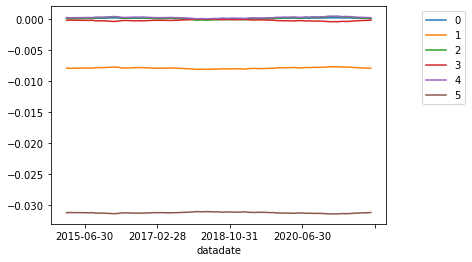

In [11]:
predicted_factors.plot()
plt.legend(bbox_to_anchor=(1.25,1))
plt.show()

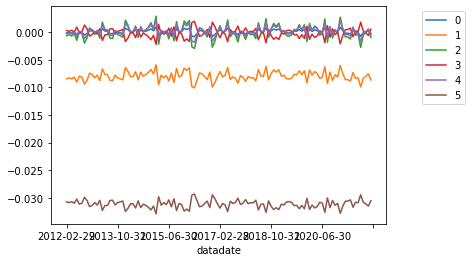

In [12]:
factors_df.plot()
plt.legend(bbox_to_anchor=(1.25,1))
plt.show()

In [13]:
predicted_returns

,3PBCP,A,AA.3,AABA,AACG,AAIC,AAL,AAMC,AAME,AAOI,...,BCTX,DIDI,DOLE,GTLB,IFBD,NTRB,PMCB,RENT,SDH,WEBR
datadate,,,,,,,,,,,,,,,,,,,,,
2015-03-31,0.009706,0.011029,0.007314,0.010827,0.015072,0.008997,0.010699,0.011845,0.012706,0.013869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,0.009696,0.012071,0.007362,0.010832,0.015414,0.009934,0.010705,0.011836,0.012692,0.011889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-31,0.009697,0.012063,0.007376,0.010832,0.015404,0.009929,0.010708,0.009939,0.013303,0.011886,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,0.010335,0.012067,0.008446,0.010467,0.015396,0.009879,0.009650,0.009960,0.013292,0.011899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-31,0.010550,0.012338,0.008453,0.010491,0.014935,0.009881,0.009672,0.008542,0.013452,0.011354,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-30,NaN,0.012628,NaN,NaN,0.015683,0.009277,0.002353,0.006495,0.010836,0.007873,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-31,NaN,0.013373,NaN,NaN,0.015472,0.009030,0.002362,0.009430,0.012435,0.008123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30,NaN,0.013374,NaN,NaN,0.015465,0.009032,0.002359,0.009434,0.012424,0.008117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
predicted_returns.rank(pct=True,axis=1,numeric_only=True,ascending=True)

,3PBCP,A,AA.3,AABA,AACG,AAIC,AAL,AAMC,AAME,AAOI,...,BCTX,DIDI,DOLE,GTLB,IFBD,NTRB,PMCB,RENT,SDH,WEBR
datadate,,,,,,,,,,,,,,,,,,,,,
2015-03-31,0.227320,0.368717,0.057143,0.343900,0.937018,0.164338,0.329718,0.489677,0.637331,0.812930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,0.229637,0.522487,0.061347,0.346943,0.954404,0.256580,0.333679,0.483523,0.634611,0.492850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-31,0.230753,0.520996,0.059078,0.349115,0.953890,0.256484,0.336970,0.257513,0.730136,0.494854,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,0.296885,0.521766,0.124613,0.309676,0.956881,0.249020,0.226738,0.257066,0.728492,0.494326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-31,0.320998,0.573707,0.126150,0.314455,0.924146,0.253936,0.232059,0.131670,0.757105,0.420568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-30,NaN,0.676003,NaN,NaN,0.972984,0.210369,0.000596,0.044895,0.378228,0.112038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-31,NaN,0.794203,NaN,NaN,0.966738,0.185762,0.000584,0.221358,0.642677,0.115736,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30,NaN,0.792881,NaN,NaN,0.966360,0.184627,0.000587,0.220027,0.642284,0.113827,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
def get_sharpes_by_decile(train_pred_dict, metric='sharpe'):
    ranked_sharpes_dict = {}
    for name, train_pred in tqdm(train_pred_dict.items(),total=len(train_pred_dict)):
        train_pred_rank = train_pred.rank(pct=True,axis=1,numeric_only=True,ascending=True)

        ranks = np.arange(0,1,.1)
        ranked_returns = []

        for r in ranks:
            port = ((train_pred_rank >= r) & (train_pred_rank < r+.1)).astype(int)
            port = port.divide(port.sum(axis=1),axis=0)
            port_returns = (port*returns_df.loc[port.index]).sum(axis=1)
            ranked_returns.append(port_returns)
            
        ranked_df = pd.concat(ranked_returns,axis=1)
        ranked_df.columns = ranks
        if metric == 'sharpe':
            ranked_sharpe = ranked_df.mean() / ranked_df.std() * np.sqrt(12)
            ranked_sharpes_dict[name] = ranked_sharpe
        elif metric == 'returns':
            ranked_sharpes_dict[name] = ranked_df.mean() * 12
        elif metric == 'volatility':
            ranked_sharpes_dict[name] = ranked_df.std() * np.sqrt(12)

    return ranked_sharpes_dict

In [16]:
sharpes = get_sharpes_by_decile(
    {'best_model':predicted_returns},
    metric='sharpe'
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]

Out of sample Sharpe Ratio (Annualized)


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
best_model,0.032,0.246,0.291,0.338,0.353,0.314,0.322,0.624,0.584,0.509


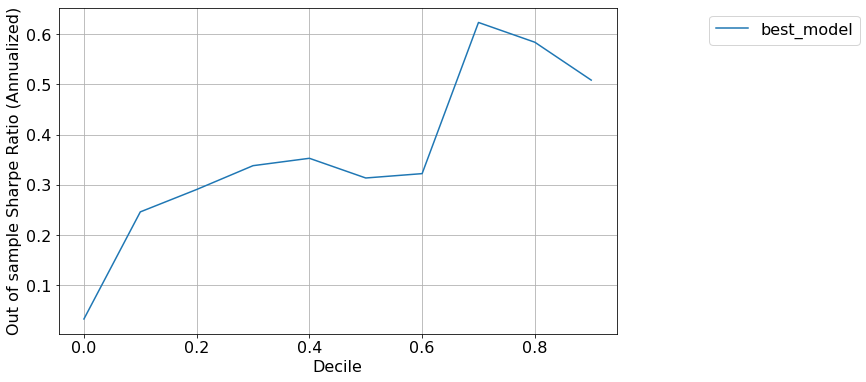

In [17]:
metric = 'sharpe'
ranked_sharpes_dict = get_sharpes_by_decile({'best_model':predicted_returns},metric=metric)
metric = {
    "returns": "Returns",
    "volatility": "Volatility",
    "sharpe": "Sharpe Ratio"
}[metric]
title = f"Out of sample {metric} (Annualized)"
plt.rcParams.update({'font.size': 16,})

pred_sharpes_df = pd.DataFrame(ranked_sharpes_dict).sort_index(axis=1)#.drop(['true_returns'],axis=1)
ax = pred_sharpes_df.plot(figsize=(10,6))
plt.xlabel("Decile")
plt.ylabel(title)
ax.legend(bbox_to_anchor=(1.45,1))
plt.grid()
print(title)
pred_sharpes_df.transpose().round(3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]

Out of sample Returns (Annualized)


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
best_model,0.008,0.058,0.062,0.068,0.072,0.062,0.061,0.118,0.113,0.106


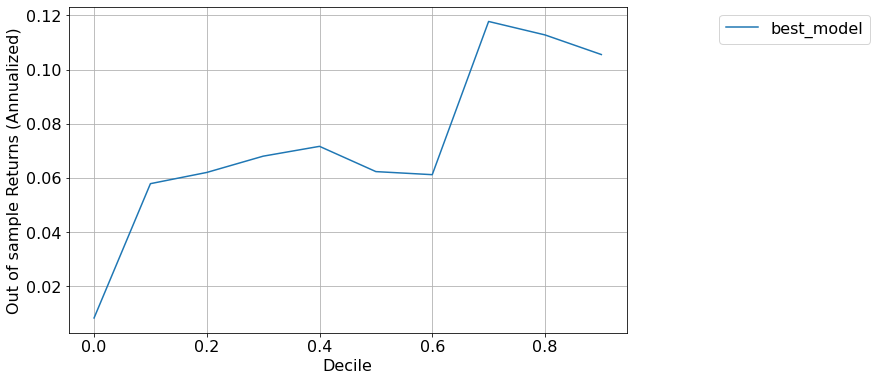

In [18]:
metric = 'returns'
ranked_sharpes_dict = get_sharpes_by_decile({'best_model':predicted_returns},metric=metric)
metric = {
    "returns": "Returns",
    "volatility": "Volatility",
    "sharpe": "Sharpe Ratio"
}[metric]
title = f"Out of sample {metric} (Annualized)"
plt.rcParams.update({'font.size': 16,})

pred_sharpes_df = pd.DataFrame(ranked_sharpes_dict).sort_index(axis=1)#.drop(['true_returns'],axis=1)
ax = pred_sharpes_df.plot(figsize=(10,6))
plt.xlabel("Decile")
plt.ylabel(title)
ax.legend(bbox_to_anchor=(1.45,1))
plt.grid()
print(title)
pred_sharpes_df.transpose().round(3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]

Out of sample Volatility (Annualized)


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
best_model,0.256,0.235,0.213,0.201,0.203,0.199,0.19,0.189,0.193,0.207


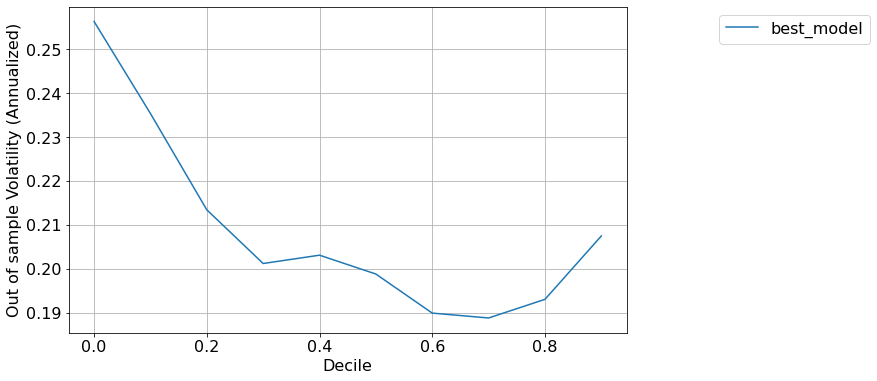

In [19]:
metric = 'volatility'
ranked_sharpes_dict = get_sharpes_by_decile({'best_model':predicted_returns},metric=metric)
metric = {
    "returns": "Returns",
    "volatility": "Volatility",
    "sharpe": "Sharpe Ratio"
}[metric]
title = f"Out of sample {metric} (Annualized)"
plt.rcParams.update({'font.size': 16,})

pred_sharpes_df = pd.DataFrame(ranked_sharpes_dict).sort_index(axis=1)#.drop(['true_returns'],axis=1)
ax = pred_sharpes_df.plot(figsize=(10,6))
plt.xlabel("Decile")
plt.ylabel(title)
ax.legend(bbox_to_anchor=(1.45,1))
plt.grid()
print(title)
pred_sharpes_df.transpose().round(3)

Annualized Return: 0.1055415252993327
Annualized SD: 0.20747138188209666
Annualized Sharpe: 0.5087040166306435


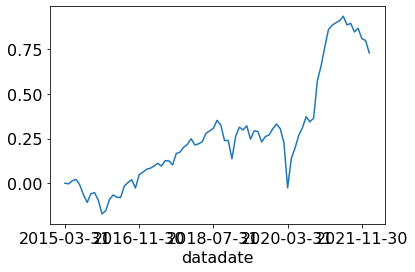

In [20]:
long_port = ((train_pred_rank >= 0.9) & (train_pred_rank < 1)).astype(int)
long_port = long_port.divide(long_port.sum(axis=1),axis=0)
long_port_returns = (long_port*returns_df.loc[long_port.index]).sum(axis=1)
long_port_returns.cumsum().plot()
print("Annualized Return:",long_port_returns.mean()*12)
print("Annualized SD:",long_port_returns.std()*np.sqrt(12))
print("Annualized Sharpe:",(long_port_returns.mean()/long_port_returns.std())*np.sqrt(12))

Annualized Return: 0.008204045322142643
Annualized SD: 0.25633410606003754
Annualized Sharpe: 0.03200528188871255


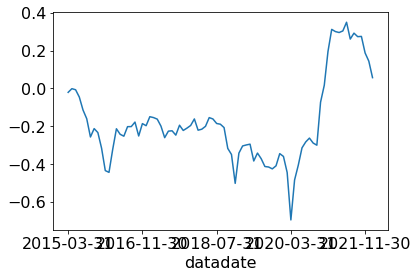

In [21]:
# train_pred_rank = train_pred.rank(pct=True,axis=1,numeric_only=True,ascending=False)
short_port = (train_pred_rank <= 0.1).astype(int)
short_port = short_port.divide(short_port.sum(axis=1),axis=0)
short_port_returns = (short_port*returns_df.loc[short_port.index]).sum(axis=1)
short_port_returns.cumsum().plot()
print("Annualized Return:",short_port_returns.mean()*12)
print("Annualized SD:",short_port_returns.std()*np.sqrt(12))
print("Annualized Sharpe:",(short_port_returns.mean()/short_port_returns.std())*np.sqrt(12))


Annualized Return: 0.09733747997719006
Annualized SD: 0.09653552392924969
Annualized Sharpe: 1.0083073672291674


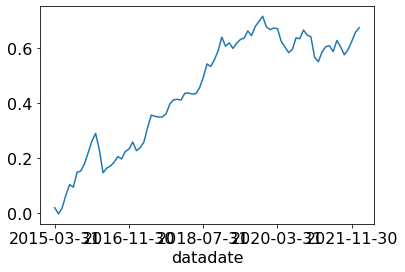

In [22]:
full_port = long_port - short_port
full_port_returns = (full_port*returns_df.loc[full_port.index]).sum(axis=1)
full_port_returns.cumsum().plot()
print("Annualized Return:",full_port_returns.mean()*12)
print("Annualized SD:",full_port_returns.std()*np.sqrt(12))
print("Annualized Sharpe:",(full_port_returns.mean()/full_port_returns.std())*np.sqrt(12))
